In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud  

import re
# import spacy
import string
# from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

# from cuml.cluster import HDBSCAN
# from cuml.manifold import UMAP

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans,AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

from warnings import simplefilter
simplefilter("ignore")

import os

data_dir = "data/"
print("Avaliable files: ")
for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Avaliable files: 
data/bbc_news_text_complexity_summarization.csv
data/bbc_text_cls.csv


In [20]:
import nltk

# First, download all necessary NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aashishd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
from IPython.display import clear_output
clear_output()


In [22]:
data = pd.read_csv('data/bbc_news_text_complexity_summarization.csv')

data.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


In [23]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')


The dataset has 2127 rows and 7 columns.


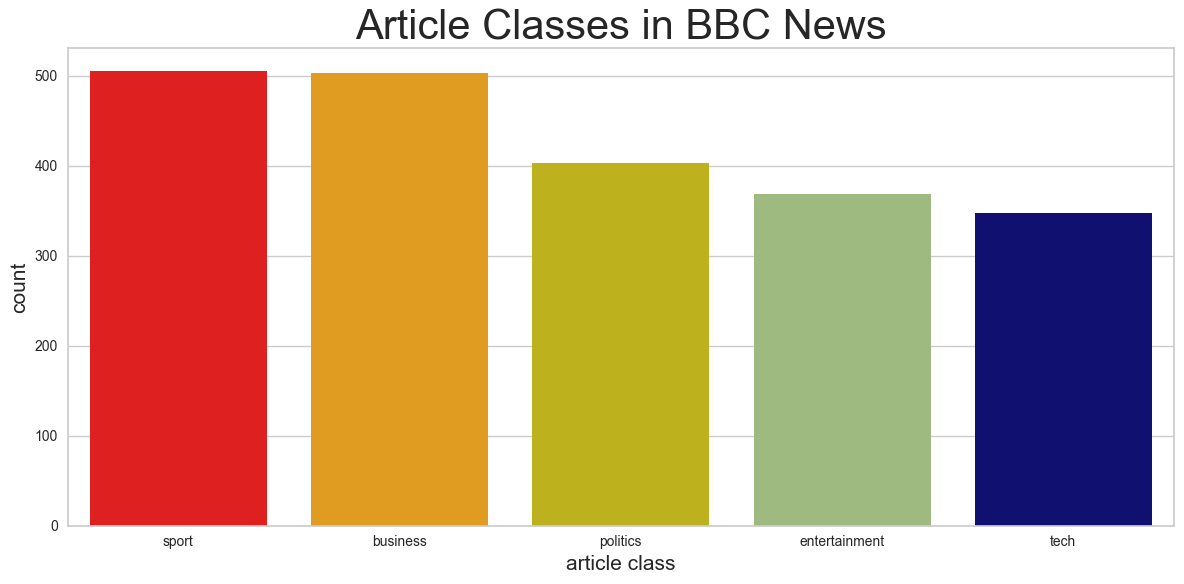

In [24]:
article_count = data.groupby('labels')['labels'].count().reset_index(name='count').sort_values(by='count',ascending=False)

plt.figure(figsize=(12,6))

sns.barplot(data=article_count,x='labels',y='count',palette=['red','orange','y','g','navy'])
plt.xlabel('article class',fontsize=15)
plt.ylabel('count',fontsize=15)
plt.title('Article Classes in BBC News',fontsize=30)

plt.tight_layout()

In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links, 
    remove punctuation and remove words containing numbers.'''
    
    # Basic text cleaning
    text = text.lower()
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'\d+', ' ', text)    
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Get stopwords
    stop = set(stopwords.words('english'))
    
    # Simple tokenization with split() instead of word_tokenize
    tokens = text.split()
    
    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop and len(word) > 2]
    
    # Simple stemming instead of lemmatization
    # Just keep tokens as they are
    
    # Join tokens back into text
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

data['clean text'] = data['text'].apply(clean_text)


[nltk_data] Downloading package punkt to /Users/aashishd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aashishd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aashishd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
### Remove common words ###
common_words = ['said']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data["clean text"] = data["clean text"].apply(text_cleaning)

data.head(2)

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary,clean text
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...,sales boost time warner profitquarterly profit...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san...",dollar gains greenspan speechthe dollar hit hi...


<Figure size 1200x600 with 0 Axes>

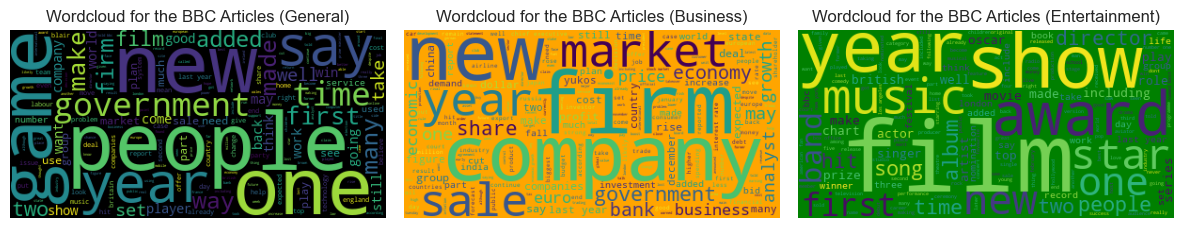

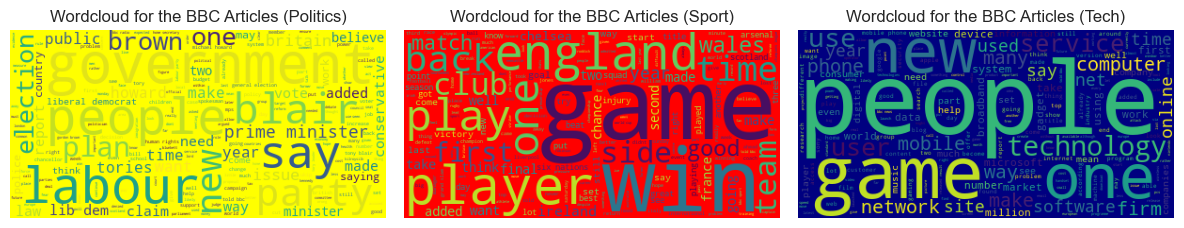

In [30]:
text = ' '.join(data['clean text'])
wordcloud = WordCloud().generate(text)

text_sport = ' '.join(data.loc[data.labels == 'sport']['clean text'])
wordcloud_sport = WordCloud(background_color="red").generate(text_sport)

text_business = ' '.join(data.loc[data.labels == 'business']['clean text'])
wordcloud_business = WordCloud(background_color="orange").generate(text_business)

text_entertainment = ' '.join(data.loc[data.labels == 'entertainment']['clean text'])
wordcloud_entertainment = WordCloud(background_color="green").generate(text_entertainment)

text_politics = ' '.join(data.loc[data.labels == 'politics']['clean text'])
wordcloud_politics = WordCloud(background_color="yellow").generate(text_politics)

text_tech = ' '.join(data.loc[data.labels == 'tech']['clean text'])
wordcloud_tech = WordCloud(background_color="navy").generate(text_tech)
###################################

fig = plt.figure(figsize=(12,6))
(topfig,bottomfig) = fig.subfigures(2,1)

### Top figures ###
topfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1.imshow(wordcloud)
ax1.axis("off")
ax1.set_title("Wordcloud for the BBC Articles (General)")

ax2.imshow(wordcloud_business)
ax2.axis("off")
ax2.set_title("Wordcloud for the BBC Articles (Business)")

ax3.imshow(wordcloud_entertainment)
ax3.axis("off")
ax3.set_title("Wordcloud for the BBC Articles (Entertainment)")

plt.tight_layout()

### Bottom figures ###
bottomfig.subplots_adjust(left=.1,right=.9,wspace=.4,hspace=.4)

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(12,6))

ax1.imshow(wordcloud_politics)
ax1.axis("off")
ax1.set_title("Wordcloud for the BBC Articles (Politics)")

ax2.imshow(wordcloud_sport)
ax2.axis("off")
ax2.set_title("Wordcloud for the BBC Articles (Sport)")

ax3.imshow(wordcloud_tech)
ax3.axis("off")
ax3.set_title("Wordcloud for the BBC Articles (Tech)")

plt.tight_layout()

#LDA topic modeling on BBC News

In [31]:
def plot_top_words(model,feature_names,n_top_words=10,color='steelblue'):
    
    if n_top_words > 5:
        fig,axes = plt.subplots(2,5,figsize=(30,15),sharex=True)
    else:
        fig,axes = plt.subplots(1,5,figsize=(30,15),sharex=True)
    axes = axes.flatten()
    
    for topic_idx,topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features,weights,height=0.7,color=color)
        ax.set_title(f"Topic {topic_idx +1}",fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both",which="major",labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(f'LDA with {n_top_words} Topics',fontsize=40)

    plt.subplots_adjust(top=0.90,bottom=0.05,wspace=0.90,hspace=0.3)
    plt.show()

In [32]:
data_sport = data.loc[data.labels == 'sport']

common_words = ['would','back','also','first','second','new','told','last','want','two','one','six']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data_sport['clean text'] = data_sport['clean text'].apply(text_cleaning)

In [33]:
vectorizer = CountVectorizer()

vect_sport = vectorizer.fit_transform(data_sport['clean text'])

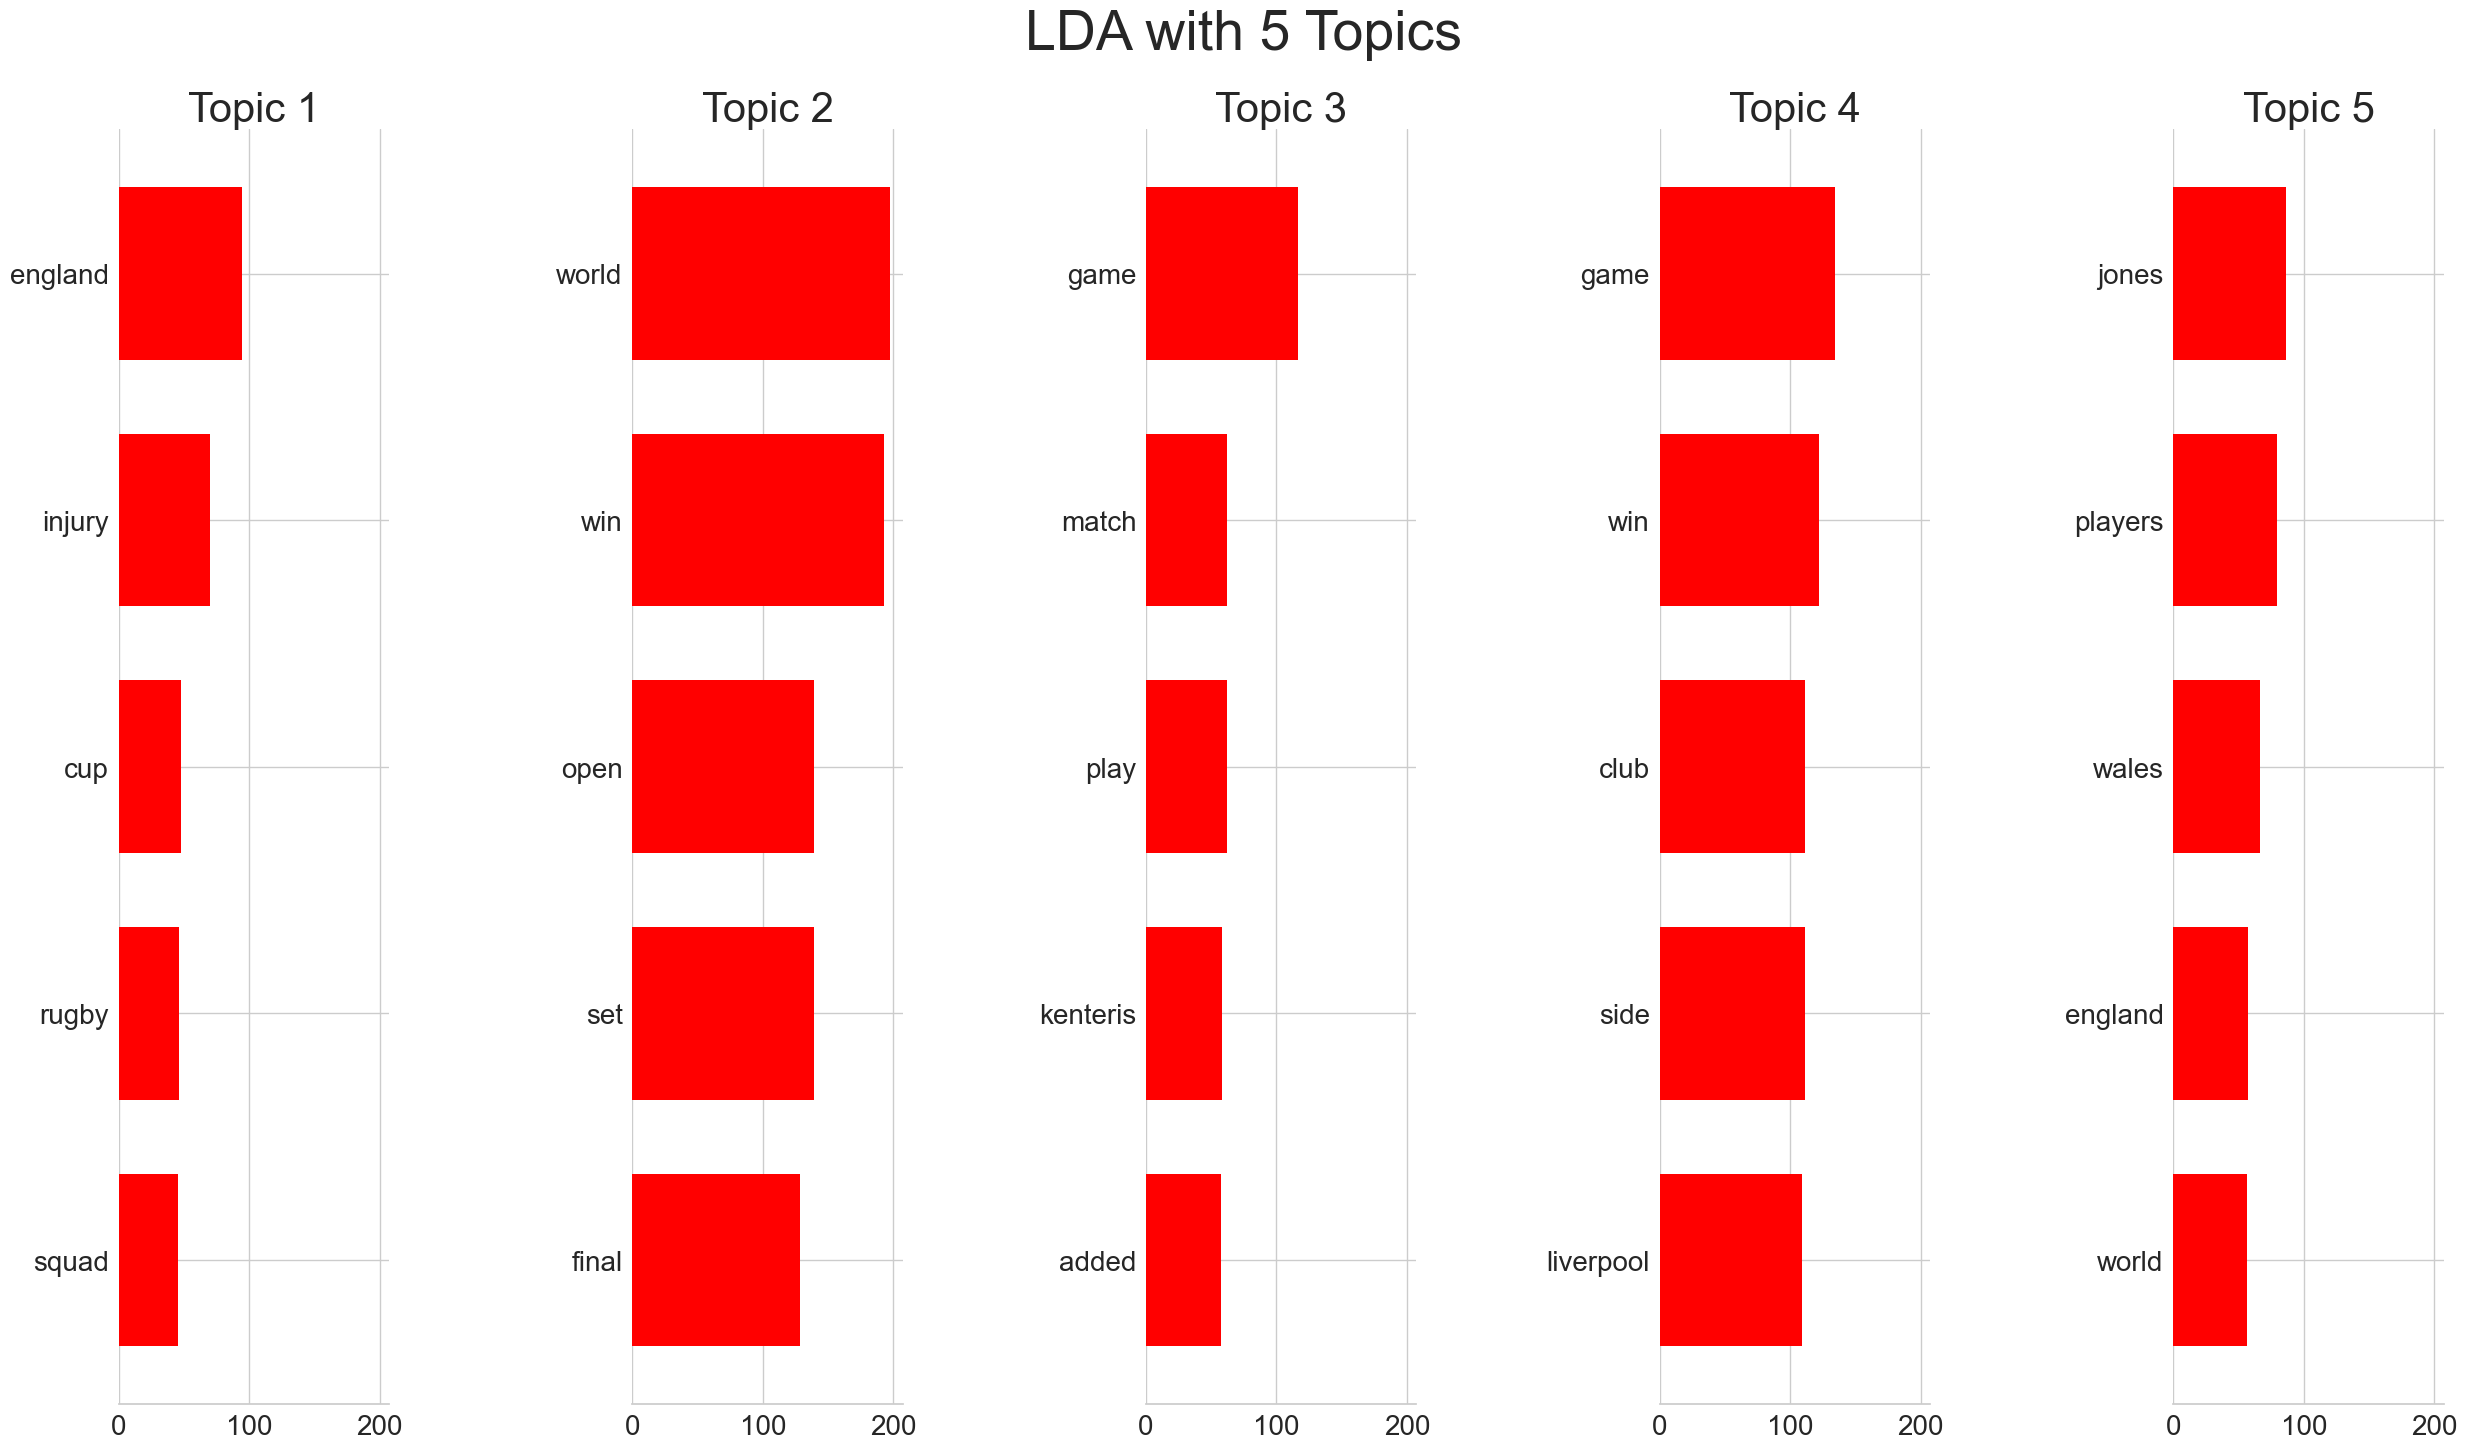

In [34]:
def LDA_text(vec,color,n_components=10):
    
    # Instantiate LDA and fit to vec
    lda = LatentDirichletAllocation(
    n_components = n_components, 
    random_state = 42,
    )

    lda.fit(vec)
    
    # Plot the results
    feature_names = vectorizer.get_feature_names_out()
    plot_top_words(lda,feature_names,n_components,color=color)


LDA_text(vect_sport,'red',5)

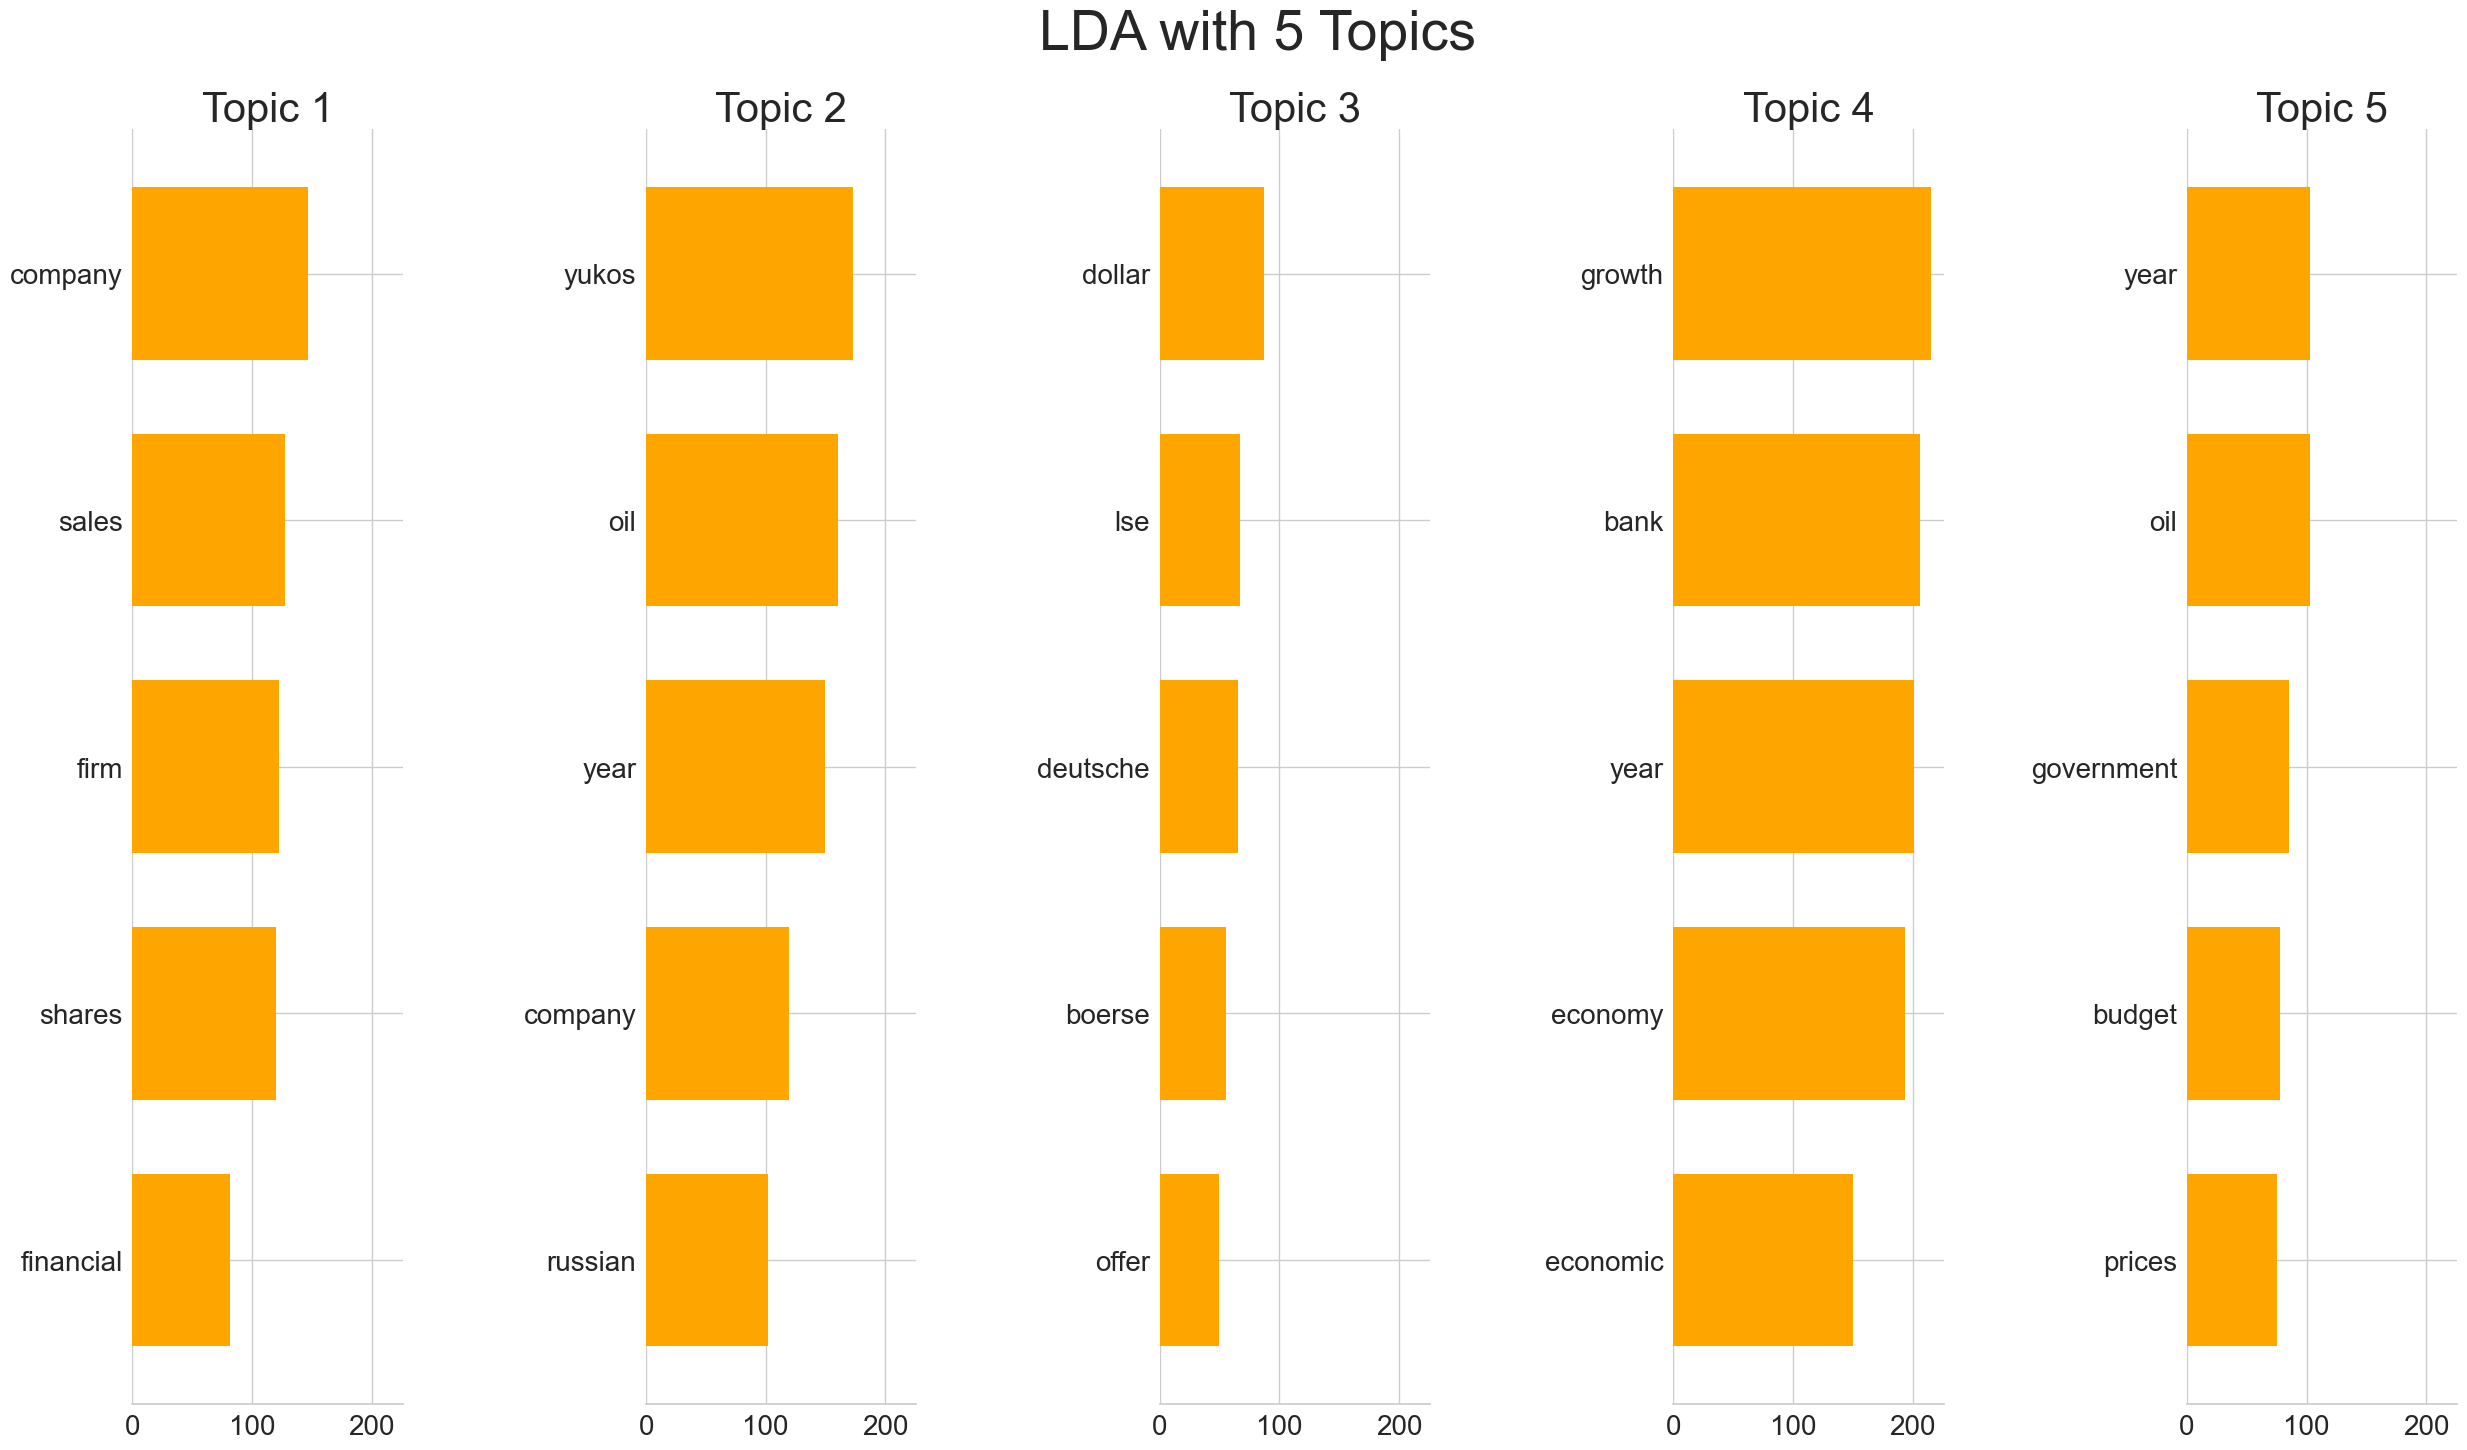

In [35]:
data_business = data.loc[data.labels == 'business']

common_words = ['would','new','also','last','could']

data_business['clean text'] = data_business['clean text'].apply(text_cleaning)

vect_business = vectorizer.fit_transform(data_business['clean text'])

LDA_text(vect_business,'orange',5)

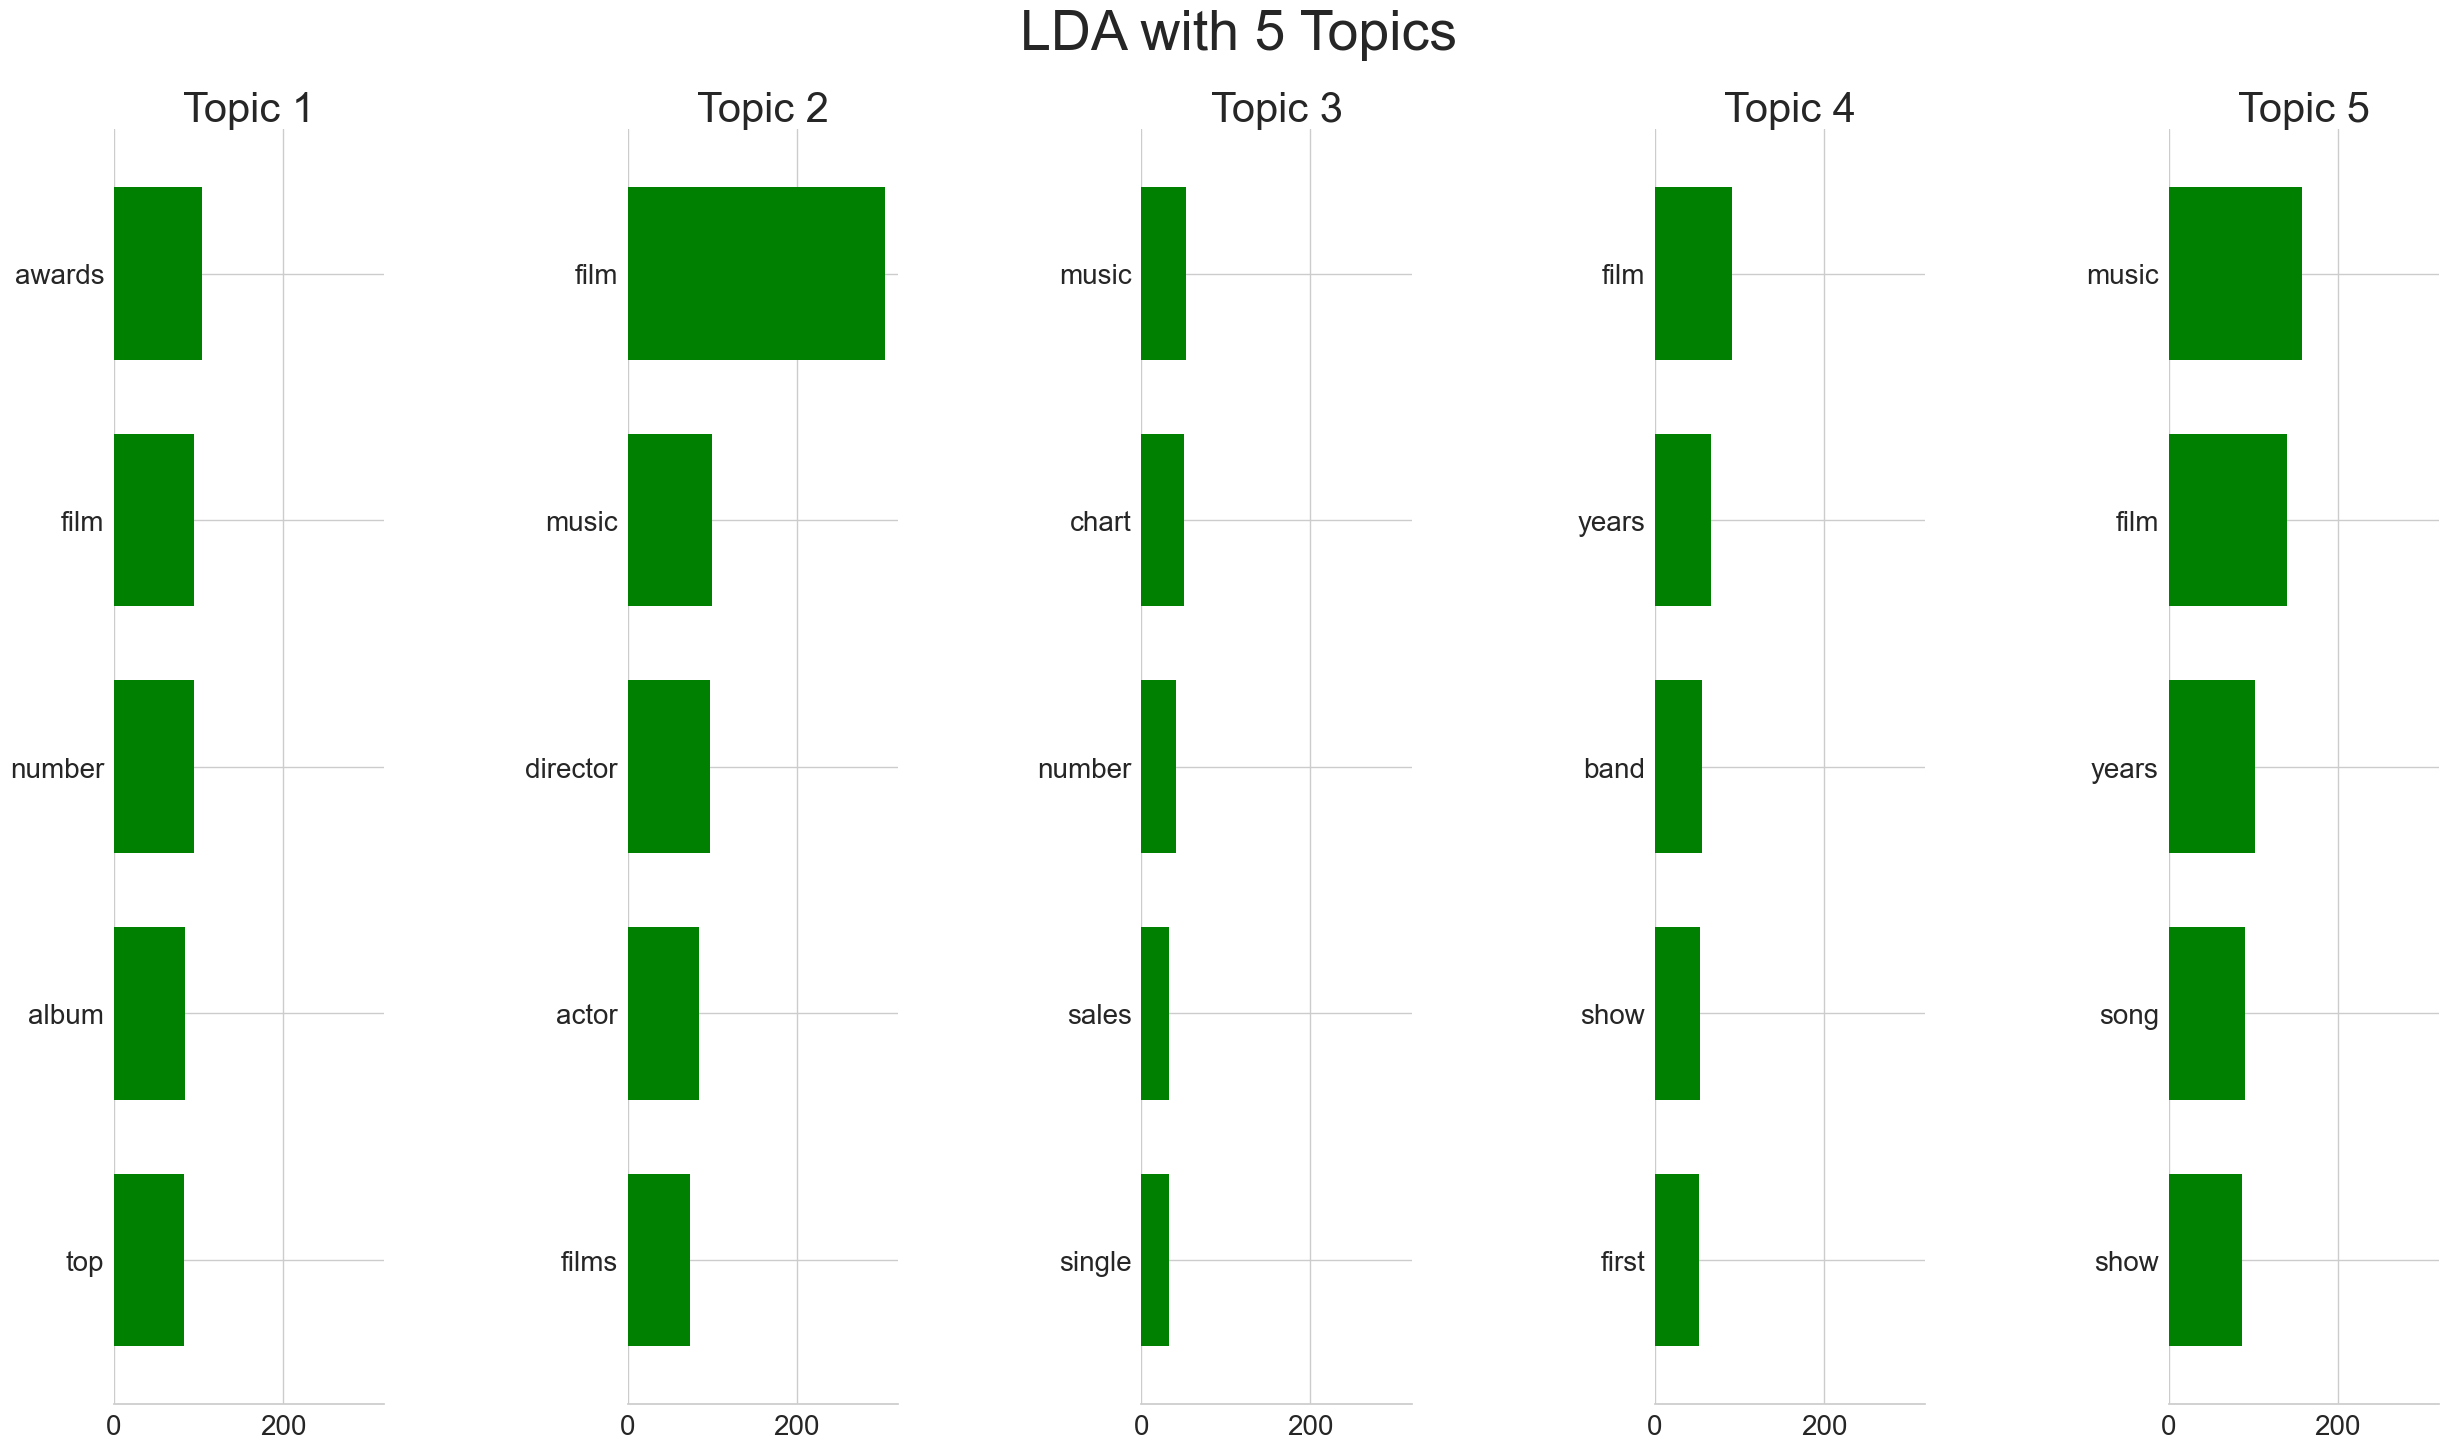

In [36]:
data_entertainment = data.loc[data.labels == 'entertainment']

common_words = ['new','one','last','best','also']

data_entertainment['clean text'] = data_entertainment['clean text'].apply(text_cleaning)

vect_entertainment = vectorizer.fit_transform(data_entertainment['clean text'])

LDA_text(vect_entertainment,'green',5)

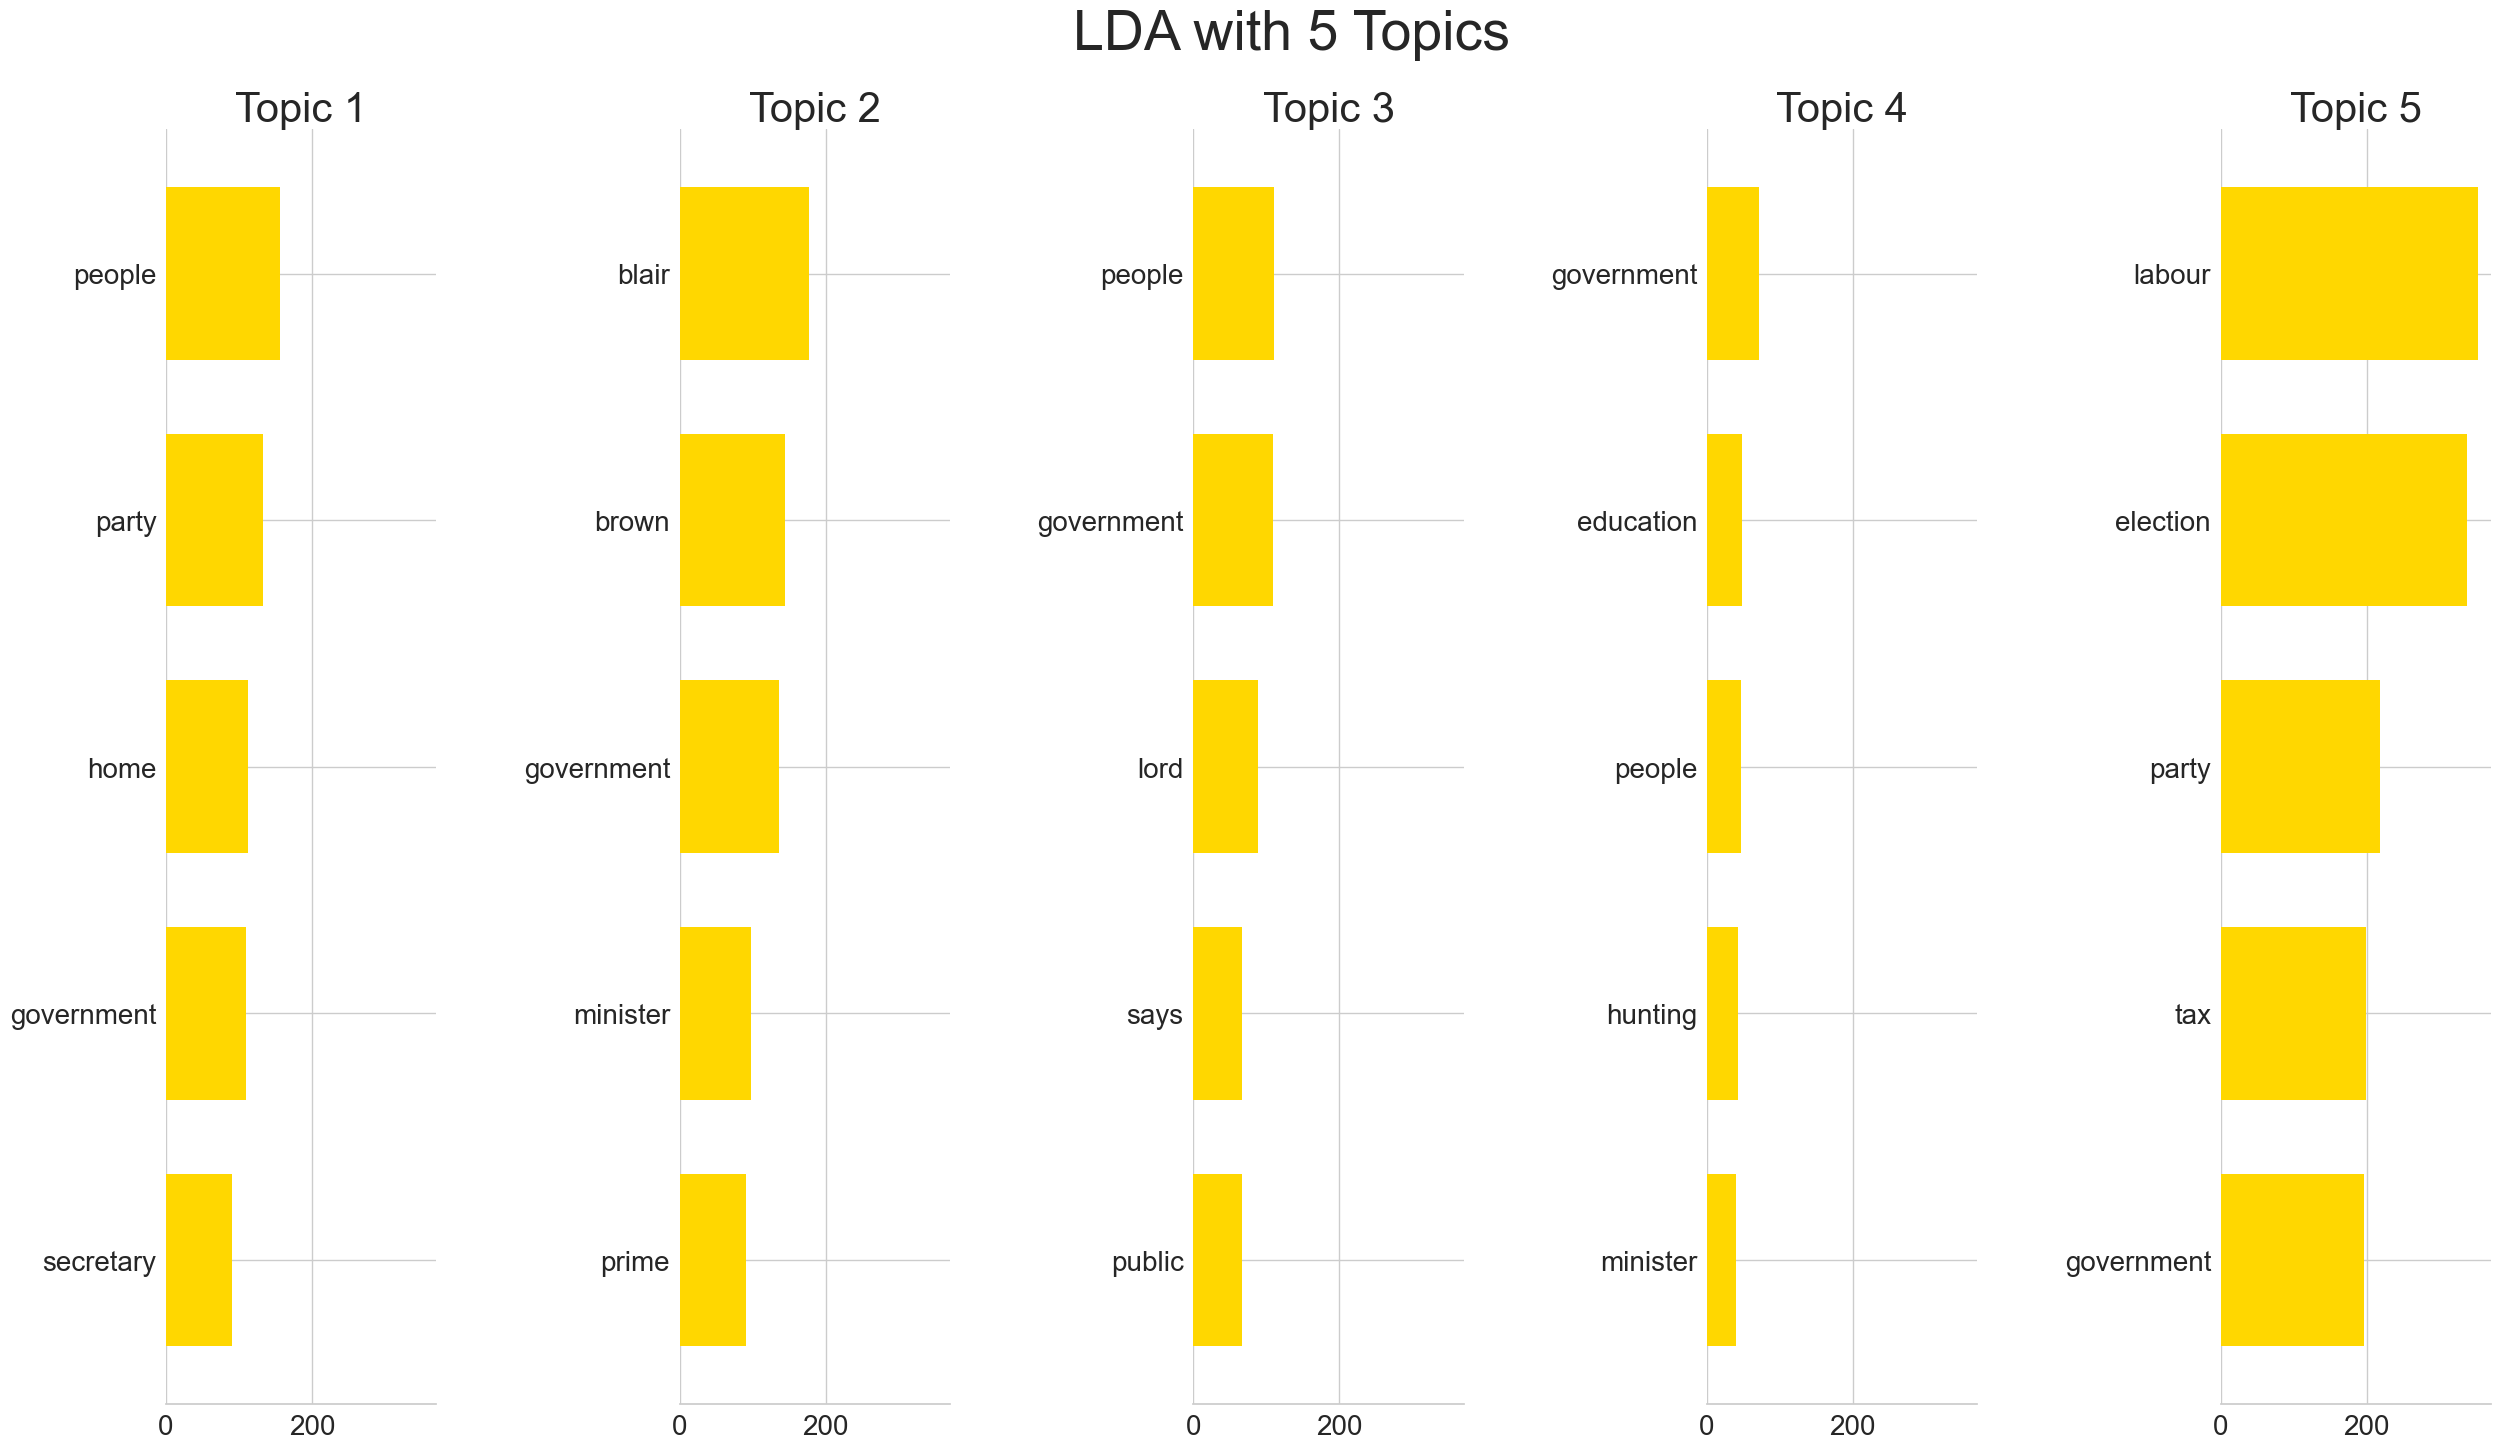

In [37]:
data_politics = data.loc[data.labels == 'politics']

common_words = ['would','also','new','told','could','one']

data_politics['clean text'] = data_politics['clean text'].apply(text_cleaning)

vect_politics = vectorizer.fit_transform(data_politics['clean text'])

LDA_text(vect_politics,'gold',5)

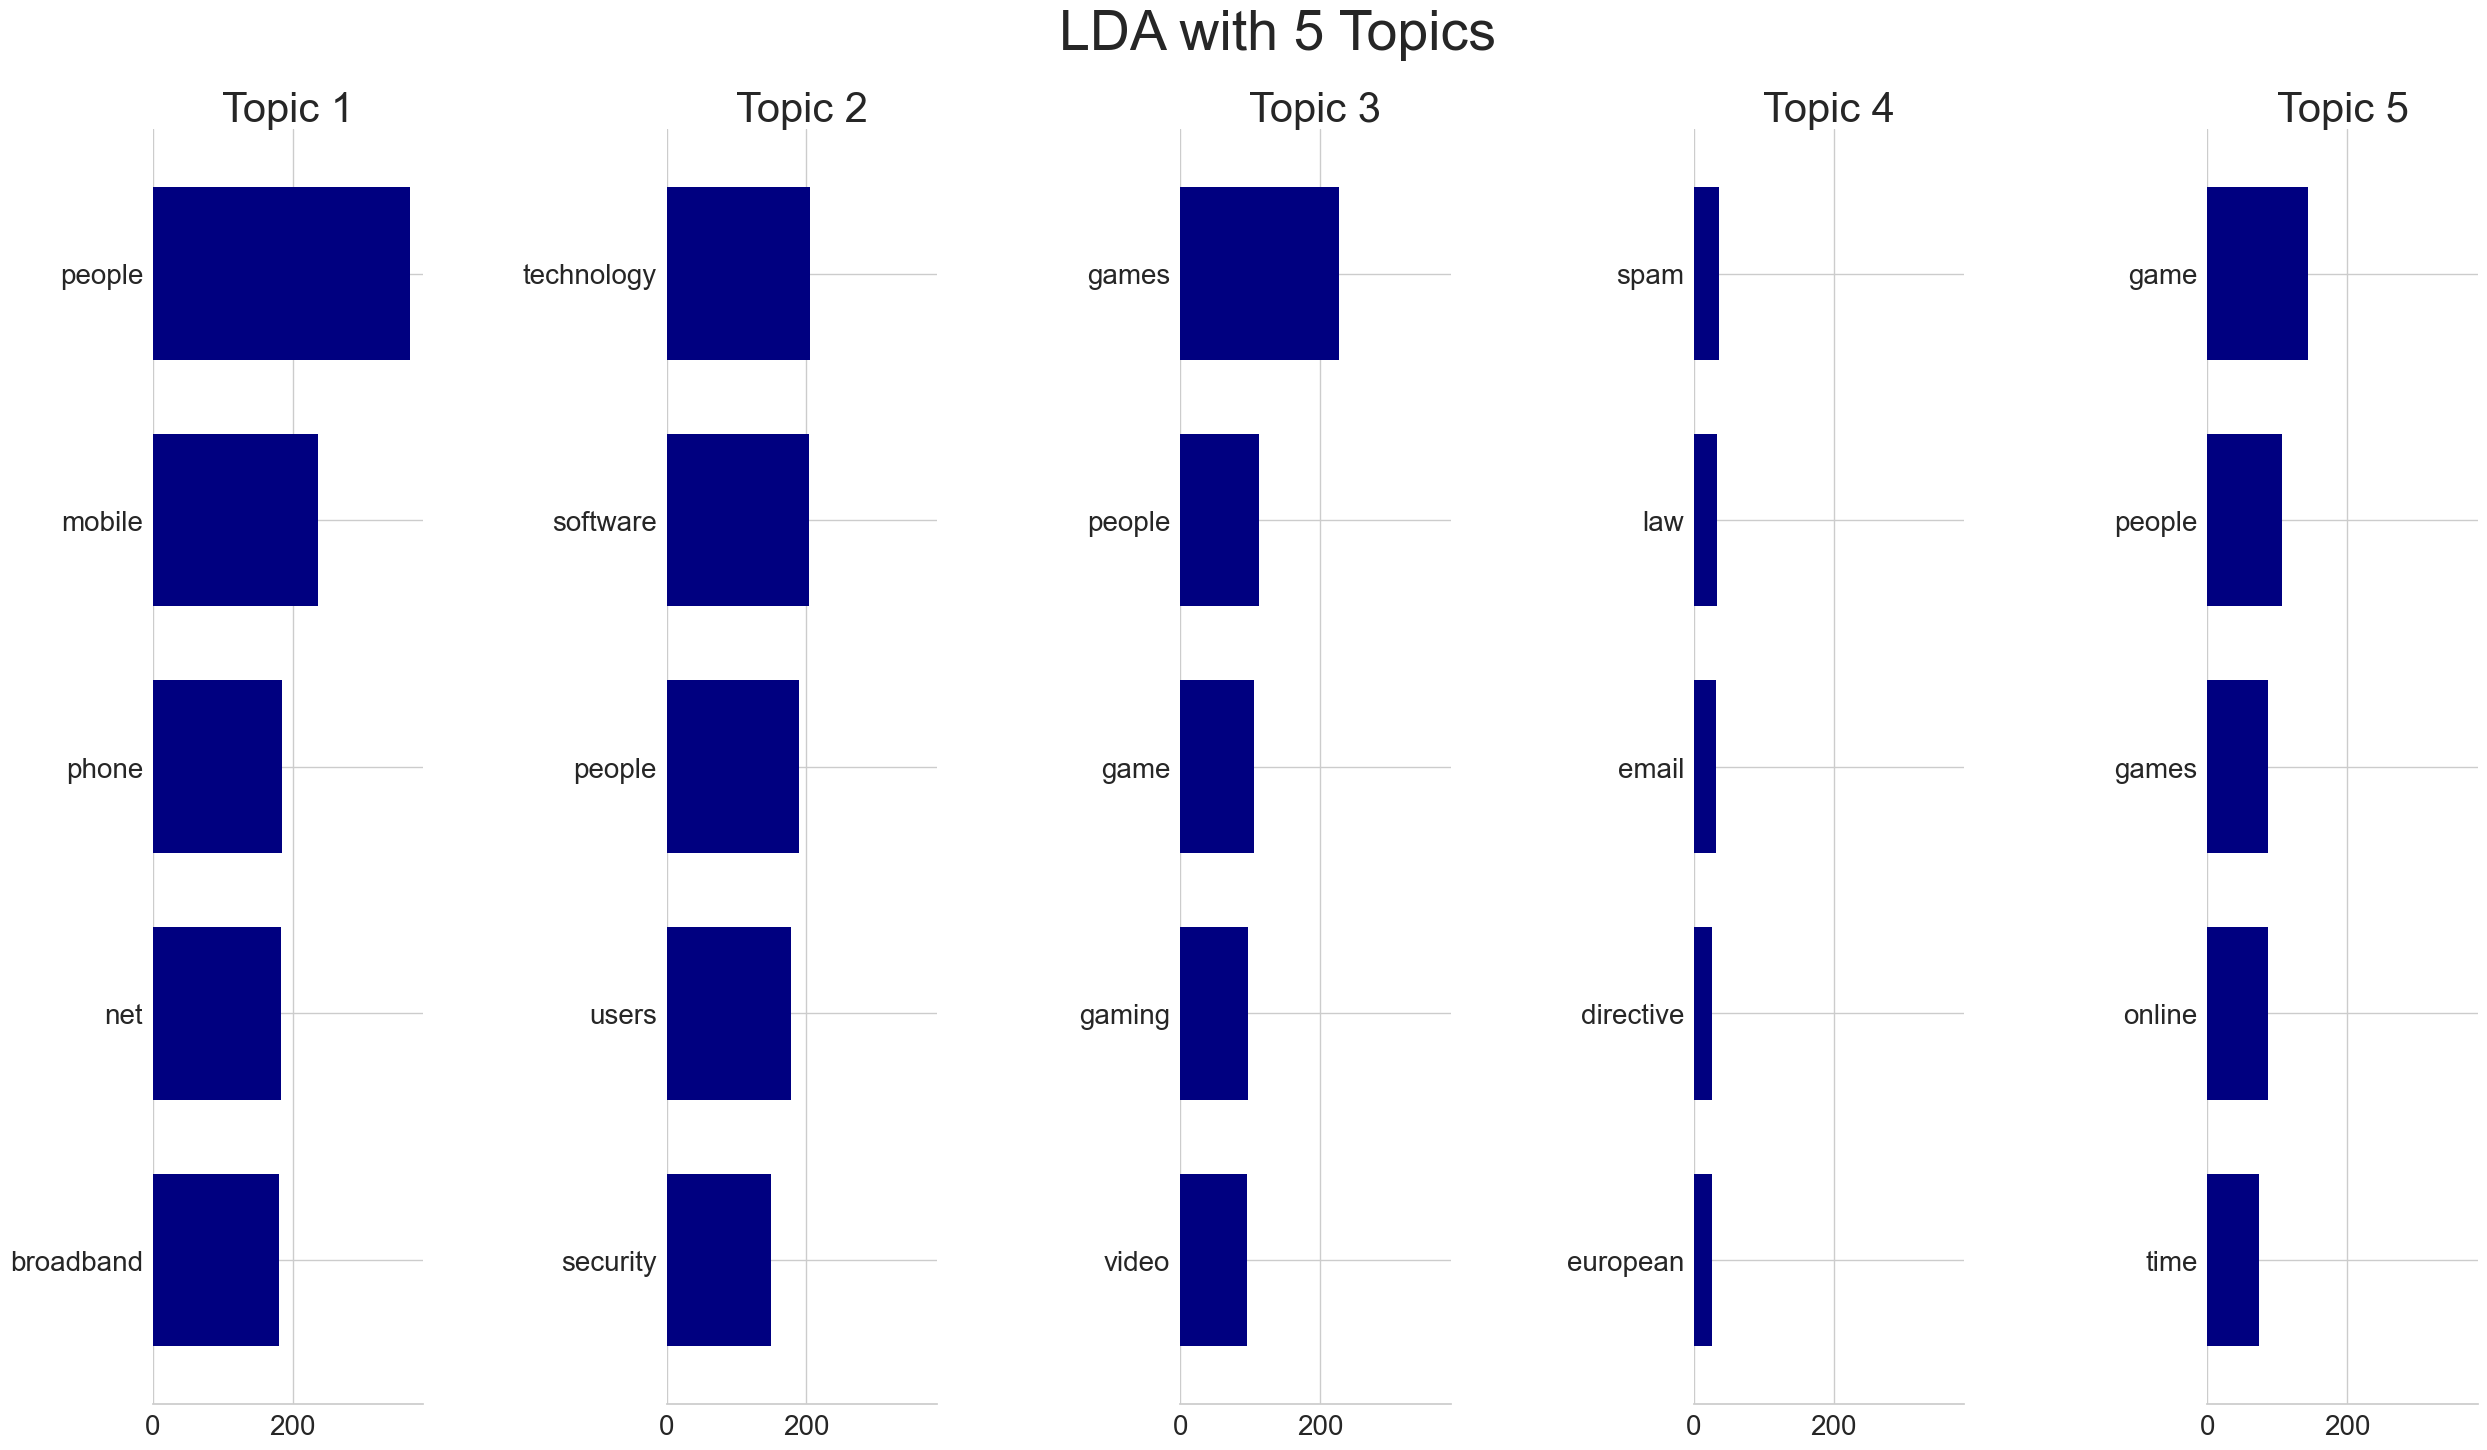

In [38]:
data_tech = data.loc[data.labels == 'tech']

common_words = ['new','one','could','also','would']

data_tech['clean text'] = data_tech['clean text'].apply(text_cleaning)

vect_tech = vectorizer.fit_transform(data_tech['clean text'])

LDA_text(vect_tech,'navy',5)